DeepGuard — Cybersecurity for Healthcare with Reinforcement Learning  

`👩‍💻 Developed as part of the AI Engineering Master – Week 8`  


📌 Project Overview  

This project applies reinforcement learning to a cybersecurity scenario in the healthcare domain using the `gym-idsgame` environment. A tabular SARSA agent and a Double Deep Q-Network (DDQN, PyTorch) are trained to defend a network against simulated attackers, modelling realistic random and maximal attack strategies. The goal is to learn adaptive defensive policies that reduce successful intrusions while keeping training and evaluation fully reproducible and explainable.


📌 Workflow Steps  

Environment & State Representation  

- Simulation environment: `idsgame-random_attack-v8` and `idsgame-maximal_attack-v8` (Markov game attacker–defender).  
- State encoding:  
  - SARSA: immutable integer tuples used as keys in a Q-table.  
  - DDQN: flattened float32 vectors, normalised for stable neural network training.  

SARSA Baseline  

- On-policy tabular SARSA with ε-greedy exploration.  
- Hyperparameters: α=0.1, γ=0.99, ε from 1.0 → 0.05 with exponential decay, 600 training episodes.  
- Attacker modelled as a random policy to provide a stochastic but stationary baseline.  

DDQN Agent  

- Architecture: 3-layer MLP (256–256–output) for Q-value approximation.  
- Stabilisation techniques: replay buffer (50k transitions), separate target network, gradient clipping.  
- Hyperparameters: γ=0.99, 600 episodes, ε from 1.0 → 0.05; lr=5e‑4 for random attack, lr=1e‑3 for maximal attack.  
- Greedy evaluation: separate testing phase with ε=0 to assess the learned policy without exploration noise.


📌 Training & Evaluation  

SARSA  

- Trained for 600 episodes on random attack v8.  
- Metrics: per-episode reward, 50-episode moving average, episode length.  
- Analysis focuses on convergence behaviour as ε decays and the moving average stabilises.  

DDQN  

- Trained on both random and maximal attack v8 scenarios with identical training loops and tuned hyperparameters.  
- Metrics: per-episode reward, 20-episode moving average, replay buffer growth, ε schedule.  
- Greedy evaluation on 10 test episodes for each scenario to measure the quality and robustness of the final defensive policy.


📌 Results  

SARSA  

- Moving average converges roughly between 0.5 and 0.7 on random attacks.  
- Final episodes (with ε≈0.05) show stable positive rewards, indicating a consistent but tabular baseline policy.  

DDQN  

- Random attack: moving average fluctuates around 0.3–0.8; greedy eval shows mostly optimal rewards with occasional failures, reflecting a reasonably effective but not fully robust policy.  
- Maximal attack: moving average increases from negative values and stabilises close to 1.0; greedy eval is almost always optimal, showing that DDQN learns a strong defence even against an aggressive attacker.  

🔗 Code and experiments available in the Week 8 portfolio notebook:  
[https://github.com/silentfortin/ai-portfolio/blob/main/08-rl-cybersec-healthcare](https://github.com/silentfortin/ai-portfolio/blob/main/08-rl-cybersec-healthcare)


In [1]:
# Install environment
!SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True pip install gym-idsgame -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 452.8/452.8 kB 9.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.0/188.0 kB 8.5 MB/s eta 0:00:00


## Environment & Setup
Install dependencies and create the `gym-idsgame` environments.


## Imports and global settings

In [2]:
import os
import random
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import gym
import gym_idsgame

from collections import deque

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [3]:
# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Reproducible seed

In [4]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

## Environment setup

In [5]:
# Create the environments for random and maximal attack scenarios
env_random = gym.make("idsgame-random_attack-v8", disable_env_checker=True)
env_maximal = gym.make("idsgame-maximal_attack-v8", disable_env_checker=True)

/usr/local/lib/python3.12/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.12/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [6]:
# Print a sample state to verify shapes
sample = env_random.reset()
print("Sample raw state (tuple of two arrays):\n", sample)
print("Observation space:", env_random.observation_space)

Sample raw state (tuple of two arrays):
 (array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]]), array([[2., 2., 2., 2., 2., 2., 2., 0., 2., 2., 2.],
       [2., 2., 2., 2., 0., 2., 2., 2., 2., 2., 2.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]))
Observation space: Box(0, 9, (1, 11), int32)


In [7]:
# Game configuration helper
game_config = env_random.idsgame_config.game_config
num_def_actions = game_config.num_defense_actions
print("Number of defender actions:", num_def_actions)

Number of defender actions: 33


## State encoding utilities
Two separate utilities:
* SARSA keys (immutable tuple of ints)
* DDQN (float32 numpy array suitable for NN input)

For the tabular SARSA agent, the environment state is converted into an immutable tuple of integers so that it can be used as a key in a Python dictionary implementing the Q‑table. This choice makes it easy to handle the large but discrete observation space and avoids imposing any particular structure on the state.
For the DDQN agent, the same state is flattened into a float32 vector and scaled by a constant factor. This normalization keeps the input values in a moderate range, which helps stabilise neural network training and makes the architecture independent of the original 2‑D matrix shape of the environment state.

In [8]:
def encode_state_key(state):
  # encode state as tuple of ints for Q-table indexing
  mat1, mat2 = state
  flat = np.concatenate([mat1.ravel(), mat2.ravel()]).astype(int)
  return tuple(flat)

def encode_state_arr(state):
  # encode state as float32 numpy array for neural networks
  mat1, mat2 = state
  flat = np.concatenate([mat1.ravel(), mat2.ravel()]).astype(np.float32)
  # normalization to keep input magnitudes moderate
  flat = flat / 10.0
  return flat

## Tabular SARSA
Implement a tabular SARSA agent using a flattened state key and train on the random-attack scenario.


In [9]:
def choose_action_sarsa(state_key, Q_table, num_actions, epsilon):
  # Epsilon-greedy selection for SARSA (tabular)
  if np.random.rand() < epsilon:
      return np.random.randint(0, num_actions)
  q_vals = [Q_table.get((state_key, a), 0.0) for a in range(num_actions)]
  q_vals = np.array(q_vals, dtype=float)
  max_val = q_vals.max()
  candidates = np.flatnonzero(q_vals == max_val)
  return int(np.random.choice(candidates))

def sarsa_update(Q_table, state_key, action, reward, next_state_key, next_action, alpha, gamma):
  # SARSA on-policy update
  q_sa = Q_table.get((state_key, action), 0.0)
  q_next = Q_table.get((next_state_key, next_action), 0.0)
  new_q = q_sa + alpha * (reward + gamma * q_next - q_sa)
  Q_table[(state_key, action)] = new_q

In [10]:
def train_sarsa(env, num_actions, n_episodes=300, alpha=0.1, gamma=0.99,
                epsilon_start=1.0, epsilon_min=0.05, epsilon_decay=0.995,
                max_steps_per_episode=1000, verbose=True):
    """Train tabular SARSA agent with epsilon-greedy exploration."""
    Q_table = {}
    epsilon = epsilon_start
    rewards_history = []
    lengths_history = []

    for episode in range(1, n_episodes + 1):
        raw = env.reset()
        state_key = encode_state_key(raw)
        action = choose_action_sarsa(state_key, Q_table, num_actions, epsilon)

        total_reward = 0.0
        steps = 0
        done = False

        while not done and steps < max_steps_per_episode:
            # Random attacker + defender action
            attack_action = np.random.randint(0, game_config.num_attack_actions)
            joint_action = (attack_action, action)

            step_out = env.step(joint_action)
            # Handle Gym v3/v4 step formats
            if len(step_out) == 4:
                next_raw, reward, done, info = step_out
            elif len(step_out) == 5:
                next_raw, reward, terminated, truncated, info = step_out
                done = bool(terminated or truncated)
            else:
                raise RuntimeError("Unexpected env.step() return length: %d" % len(step_out))

            # Extract defender reward
            def_reward = reward[1] if isinstance(reward, (list, tuple, np.ndarray)) else float(reward)

            next_state_key = encode_state_key(next_raw)
            next_action = choose_action_sarsa(next_state_key, Q_table, num_actions, epsilon)

            # SARSA update: Q(s,a) ← Q(s,a) + α[r + γQ(s',a') - Q(s,a)]
            sarsa_update(Q_table, state_key, action, def_reward, next_state_key, next_action, alpha, gamma)

            # advance state-action pair
            state_key = next_state_key
            action = next_action
            total_reward += def_reward
            steps += 1

        # epsilon decay
        epsilon = max(epsilon_min, epsilon * epsilon_decay)

        rewards_history.append(total_reward)
        lengths_history.append(steps)

        if verbose and episode % 50 == 0:
            avg_last = np.mean(rewards_history[-50:])
            print(f"SARSA Episode {episode}/{n_episodes} - avg_last50: {avg_last:.2f} - eps: {epsilon:.3f}")

    return Q_table, rewards_history, lengths_history

## Simple evaluation helper

In [11]:
def evaluate_ddqn(env, net, n_episodes=10, greedy=True):
    """Evaluate DDQN agent on environment using greedy policy (no epsilon-greedy)."""
    rewards = []
    for ep in range(n_episodes):
        raw = env.reset()
        state_vec = encode_state_arr(raw)
        done = False
        total = 0.0
        steps = 0
        while not done and steps < 2000:
            with torch.no_grad():
                st = torch.tensor(state_vec, dtype=torch.float32, device=device).unsqueeze(0)
                qvals = net(st)
                # Greedy: select max Q-value action
                action_def = int(qvals.argmax(dim=1).item())
                attack_action = np.random.randint(0, game_config.num_attack_actions)
                joint_action = (attack_action, action_def)

                step_out = env.step(joint_action)
                # Handle Gym v3/v4 step() return formats
                if len(step_out) == 4:
                    next_raw, reward, done, info = step_out
                elif len(step_out) == 5:
                    next_raw, reward, terminated, truncated, info = step_out
                    done = bool(terminated or truncated)
                else:
                    raise RuntimeError("Unexpected env.step() return length")

                reward_def = reward[1] if isinstance(reward, (list, tuple, np.ndarray)) else float(reward)
                state_vec = encode_state_arr(next_raw)
                total += reward_def
                steps += 1
        rewards.append(total)
    return rewards


## Double DQN (DDQN) with PyTorch
Implement DDQN (online + target networks, replay buffer) and train on both random and maximal attack scenarios.


In [12]:
class DDQNNetwork(nn.Module):
    """Simple MLP for Double DQN value approximation"""

    def __init__(self, input_dim, output_dim):
        """Initialize 3-layer MLP: input_dim -> 256 -> 256 -> output_dim"""
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, output_dim)
        )

    def forward(self, x):
        """forward pass through MLP"""
        return self.net(x)

In [13]:
class ReplayBuffer:
    """Device-aware replay buffer for storing and sampling RL transitions."""

    def __init__(self, capacity=50000, device='cpu'):
        """Initialize buffer with max capacity and target device"""
        self.capacity = capacity
        self.buffer = deque(maxlen=capacity)
        self.device = device

    def push(self, transition):
        """Add transition tuple: (state_np, action_int, reward_float, next_state_np, done_float)"""
        self.buffer.append(transition)

    def sample(self, batch_size):
        """Randomly sample batch_size transitions and convert to tensors on self.device"""
        batch = random.sample(self.buffer, batch_size)
        s, a, r, ns, d = zip(*batch)
        states = torch.tensor(np.stack(s), dtype=torch.float32, device=self.device)
        actions = torch.tensor(a, dtype=torch.long, device=self.device)
        rewards = torch.tensor(r, dtype=torch.float32, device=self.device)
        next_states = torch.tensor(np.stack(ns), dtype=torch.float32, device=self.device)
        dones = torch.tensor(d, dtype=torch.float32, device=self.device)
        return states, actions, rewards, next_states, dones

    def __len__(self):
        """Return current buffer size"""
        return len(self.buffer)

In [14]:
def ddqn_update(online_net, target_net, buffer, optimizer, batch_size, gamma, device):
    """Single DDQN minibatch update using Double DQN target calculation"""
    if len(buffer) < batch_size:
        return None

    states, actions, rewards, next_states, dones = buffer.sample(batch_size)

    # Q(s,a) predicted by online network
    q_values = online_net(states)

    # DDQN: online selects best action, target evaluates it
    next_q_online = online_net(next_states)
    next_q_target = target_net(next_states)
    best_actions = next_q_online.argmax(dim=1)
    next_q_target_best = next_q_target.gather(1, best_actions.unsqueeze(1)).squeeze(1)

    # TD target: r + γ * Q_target(s', argmax_a Q_online(s',a)) * (1-done)
    target_q = rewards + gamma * next_q_target_best * (1 - dones)
    q_pred = q_values.gather(1, actions.unsqueeze(1)).squeeze(1)

    loss = F.mse_loss(q_pred, target_q.detach())
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(online_net.parameters(), max_norm=10)
    optimizer.step()

    return loss.item()

In [15]:
def train_ddqn(
    env,
    n_episodes=500,
    batch_size=64,
    gamma=0.99,
    lr=1e-3,
    replay_capacity=50000,
    epsilon_start=1.0,
    epsilon_end=0.05,
    epsilon_decay=0.9995,
    target_update_freq=200,
    device=device,
    verbose=True,
    checkpoint_path="ddqn_checkpoint.pt",
    checkpoint_every=200,
):
    """Train Double DQN agent with replay buffer and target network."""
    # get input dimensions
    sample_raw = env.reset()
    sample_vec = encode_state_arr(sample_raw)
    input_dim = len(sample_vec)
    num_actions = env.idsgame_config.game_config.num_defense_actions

    if verbose:
        print(f"DDQN input_dim={input_dim}, num_actions={num_actions}, device={device}")

    # initialize online/target networks
    online_net = DDQNNetwork(input_dim=input_dim, output_dim=num_actions).to(device)
    target_net = DDQNNetwork(input_dim=input_dim, output_dim=num_actions).to(device)
    target_net.load_state_dict(online_net.state_dict())

    optimizer = optim.Adam(online_net.parameters(), lr=lr)
    replay_buffer = ReplayBuffer(capacity=replay_capacity, device=device)

    epsilon = epsilon_start
    rewards_history = []
    losses = []

    for episode in range(1, n_episodes + 1):
        raw = env.reset()
        state_vec = encode_state_arr(raw)
        total_reward = 0.0
        done = False
        steps = 0

        while not done:
            # epsilon greedy action selection
            if random.random() < epsilon:
                action_def = random.randint(0, num_actions - 1)
            else:
                with torch.no_grad():
                    st = torch.tensor(state_vec, dtype=torch.float32, device=device).unsqueeze(0)
                    qvals = online_net(st)
                    action_def = int(qvals.argmax(dim=1).item())

            # random attacker + defender action
            attack_action = random.randint(0, env.idsgame_config.game_config.num_attack_actions - 1)
            joint_action = (attack_action, action_def)

            step_out = env.step(joint_action)
            # handle Gym v3/v4 step formats
            if len(step_out) == 4:
                next_raw, reward, done, info = step_out
            elif len(step_out) == 5:
                next_raw, reward, terminated, truncated, info = step_out
                done = bool(terminated or truncated)
            else:
                raise RuntimeError("Unexpected env.step() return length")

            next_state_vec = encode_state_arr(next_raw)
            reward_def = reward[1] if isinstance(reward, (list, tuple, np.ndarray)) else float(reward)

            # store transition in replay buffer
            replay_buffer.push((state_vec, action_def, float(reward_def), next_state_vec, float(done)))

            # DDQN update
            loss = ddqn_update(online_net, target_net, replay_buffer, optimizer, batch_size, gamma, device)
            if loss is not None:
                losses.append(loss)

            state_vec = next_state_vec
            total_reward += reward_def
            steps += 1

            # safety cap
            if steps > 5000:
                break

        # epsilon decay and update target network
        epsilon = max(epsilon_end, epsilon * epsilon_decay)
        if episode % target_update_freq == 0:
            target_net.load_state_dict(online_net.state_dict())

        rewards_history.append(total_reward)

        # periodic checkpoint
        if checkpoint_path is not None and episode % checkpoint_every == 0:
            torch.save({
                "episode": episode,
                "model_state_dict": online_net.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "epsilon": epsilon,
                "rewards_history": rewards_history,
            }, checkpoint_path)
            if verbose:
                print(f"Checkpoint saved at episode {episode} to {checkpoint_path}")

        if verbose and episode % 20 == 0:
            avg_last = np.mean(rewards_history[-20:])
            print(f"DDQN Episode {episode}/{n_episodes} - avg_last20: {avg_last:.2f} - eps: {epsilon:.3f} - buffer_len: {len(replay_buffer)}")

    # final save
    if checkpoint_path is not None:
        torch.save({"model_state_dict": online_net.state_dict()}, checkpoint_path.replace(".pt", "_final.pt"))

    return online_net, rewards_history, losses

## Results and Evaluation
Plot learning curves and evaluate greedy performance of the trained DDQN agents.


# SARSA

The tabular SARSA algorithm is used as a baseline because it is simple, on‑policy and well suited to problems where the state and action spaces are discrete. In the random attack v8 scenario the attacker behaves stochastically, so an on‑policy method that updates Q(s,a) with the actually executed action
a′ is appropriate and tends to produce safer policies.
I use a learning rate α=0.1 and discount factor γ=0.99 to give more weight to long term defensive rewards. In this experiment I train the SARSA agent for 600 episodes in the random attack v8 environment, which is long enough for ε to decay from 1.0 to its minimum value 0.05 and for the learning curve to stabilise. The cap on the number of steps per episode prevents very long episodes from dominating training and keeps the computational cost manageable.

SARSA Episode 50/600 - avg_last50: 0.58 - eps: 0.778
SARSA Episode 100/600 - avg_last50: 0.82 - eps: 0.606
SARSA Episode 150/600 - avg_last50: 0.46 - eps: 0.471
SARSA Episode 200/600 - avg_last50: 0.70 - eps: 0.367
SARSA Episode 250/600 - avg_last50: 0.58 - eps: 0.286
SARSA Episode 300/600 - avg_last50: 0.76 - eps: 0.222
SARSA Episode 350/600 - avg_last50: 0.52 - eps: 0.173
SARSA Episode 400/600 - avg_last50: 0.34 - eps: 0.135
SARSA Episode 450/600 - avg_last50: 0.40 - eps: 0.105
SARSA Episode 500/600 - avg_last50: 0.40 - eps: 0.082
SARSA Episode 550/600 - avg_last50: 0.64 - eps: 0.063
SARSA Episode 600/600 - avg_last50: 0.64 - eps: 0.050


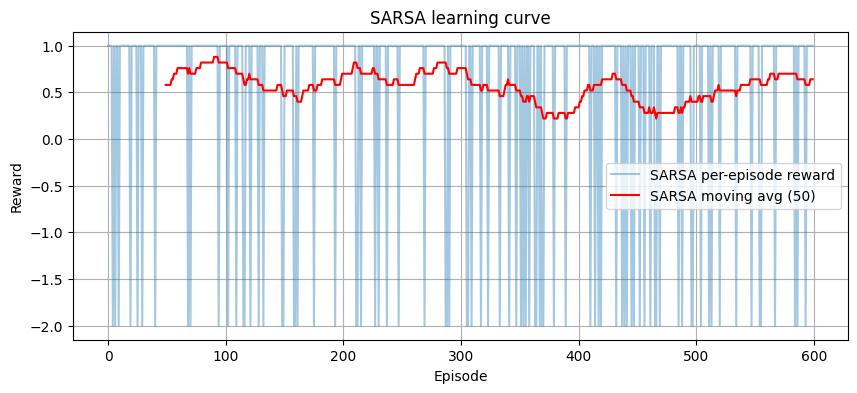

In [16]:
# Train SARSA
Q_sarsa, rewards_sarsa, lengths_sarsa = train_sarsa(env_random, num_def_actions, n_episodes=600, verbose=True)

# Plot SARSA results
plt.figure(figsize=(10, 4))
plt.plot(rewards_sarsa, alpha=0.4, label='SARSA per-episode reward')
plt.plot(pd.Series(rewards_sarsa).rolling(50).mean(), label='SARSA moving avg (50)', color='red')
plt.legend(); plt.title("SARSA learning curve"); plt.xlabel("Episode"); plt.ylabel("Reward"); plt.grid(True); plt.show()

The plot shows the reward per episode (blue line) and the moving average over the last 50 episodes (red line).
At the beginning ε is high and the agent explores a lot, but the moving average settles between 0.5 and 0.7; as ε decreases to the minimum value 0.05, the policy becomes more stable.
In the last 50 episodes, with ε fixed, the average reward is about 0.64, which indicates that the agent has learned a defensive strategy that, despite the natural variability of the stochastic environment, yields overall good and stable performance.

# DDQN

The DDQN agent is implemented with a two‑layer MLP of size 256–256, which is a reasonable compromise between expressive power and computational cost given the 66‑dimensional input state and 33 possible defender actions. The use of a replay buffer and a separate target network follows standard deep Q‑learning practice and is crucial to stabilise training in this non‑linear function approximation setting.
The replay buffer stores up to 50,000 transitions and is sampled uniformly to decorrelate updates and reuse past experience efficiently. The target network is updated every 50 episodes to provide a slowly changing bootstrap target, reducing oscillations. The discount factor γ=0.99 reflects the long‑term nature of security decisions, while the learning rate is set to 5e‑4 for the random attack scenario and 1e‑3 for the maximal attack scenario to balance stability and speed of convergence.
Finally, I train for 600 episodes in both environments. This length allows ε to decay from 1.0 to its minimum value 0.05, so that the agent spends the first part of training exploring and the last part exploiting the learned policy. The greedy evaluation at the end of training isolates the performance of the learned policy from the exploration noise and provides a clearer picture of the defensive capabilities of the agent.

In [17]:
# Train DDQN on random attack
net_ddqn_random, rewards_ddqn_random, losses_random = train_ddqn(
    env_random,
    n_episodes=600,
    batch_size=32,
    gamma=0.99,
    lr=5e-4,
    replay_capacity=50000,
    epsilon_start=1.0,
    epsilon_end=0.05,
    epsilon_decay=0.995, # !seems better value (keep it)
    target_update_freq=50,
    device=device,
    verbose=True,
    checkpoint_path="ddqn_random.pt",
    checkpoint_every=250
)

# Evaluate DDQN random (greedy)
eval_rewards_random = evaluate_ddqn(env_random, net_ddqn_random, n_episodes=10, greedy=True)
print("DDQN random eval rewards (greedy):", eval_rewards_random)

# Train DDQN on maximal attack
net_ddqn_max, rewards_ddqn_maximal, losses_max = train_ddqn(
    env_maximal,
    n_episodes=600,
    batch_size=32,
    gamma=0.99,
    lr=1e-3,
    replay_capacity=50000,
    epsilon_start=1.0,
    epsilon_end=0.05,
    epsilon_decay=0.995,
    target_update_freq=50,
    checkpoint_path="ddqn_max.pt",
    checkpoint_every=250
)

# Evaluate DDQN maximal (greedy)
eval_rewards_max = evaluate_ddqn(env_maximal, net_ddqn_max, n_episodes=10, greedy=True)
print("DDQN maximal eval rewards (greedy):", eval_rewards_max)

DDQN input_dim=66, num_actions=33, device=cpu
DDQN Episode 20/600 - avg_last20: 0.70 - eps: 0.905 - buffer_len: 81


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


DDQN Episode 40/600 - avg_last20: 0.55 - eps: 0.818 - buffer_len: 176
DDQN Episode 60/600 - avg_last20: -0.05 - eps: 0.740 - buffer_len: 300
DDQN Episode 80/600 - avg_last20: 0.55 - eps: 0.670 - buffer_len: 400
DDQN Episode 100/600 - avg_last20: 0.25 - eps: 0.606 - buffer_len: 502
DDQN Episode 120/600 - avg_last20: 0.55 - eps: 0.548 - buffer_len: 592
DDQN Episode 140/600 - avg_last20: 0.40 - eps: 0.496 - buffer_len: 662
DDQN Episode 160/600 - avg_last20: 0.85 - eps: 0.448 - buffer_len: 754
DDQN Episode 180/600 - avg_last20: 0.40 - eps: 0.406 - buffer_len: 848
DDQN Episode 200/600 - avg_last20: 0.25 - eps: 0.367 - buffer_len: 917
DDQN Episode 220/600 - avg_last20: 0.85 - eps: 0.332 - buffer_len: 997
DDQN Episode 240/600 - avg_last20: 0.25 - eps: 0.300 - buffer_len: 1095
Checkpoint saved at episode 250 to ddqn_random.pt
DDQN Episode 260/600 - avg_last20: 0.40 - eps: 0.272 - buffer_len: 1216
DDQN Episode 280/600 - avg_last20: 0.70 - eps: 0.246 - buffer_len: 1301
DDQN Episode 300/600 - avg

In [18]:
# moving averages
ma_random = pd.Series(rewards_ddqn_random).rolling(20, min_periods=1).mean()
ma_maximal = pd.Series(rewards_ddqn_maximal).rolling(20, min_periods=1).mean()

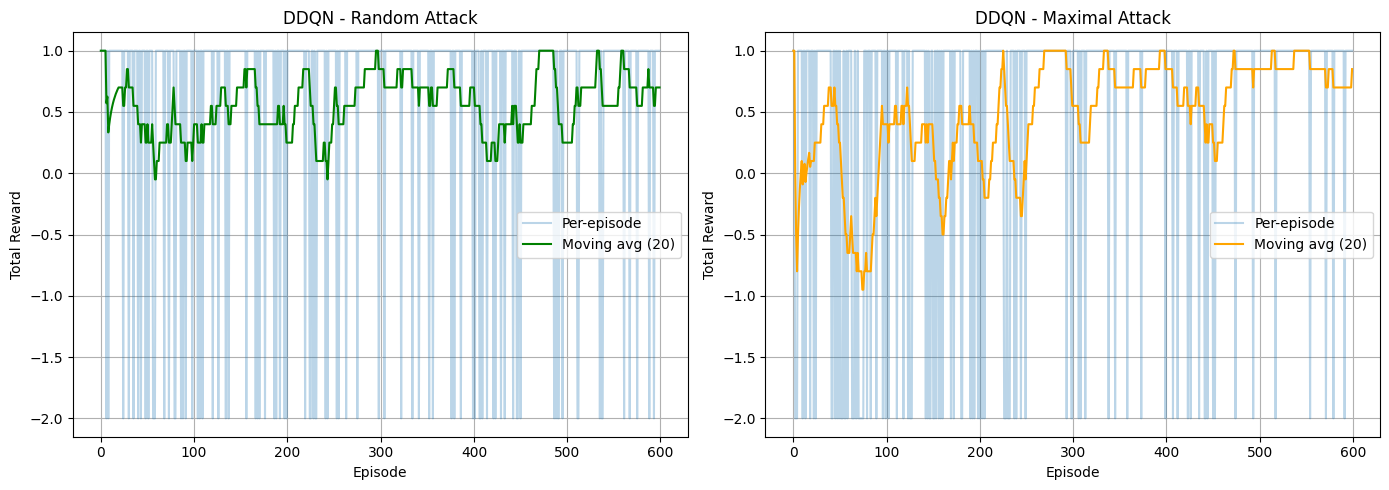

In [19]:
plt.figure(figsize=(14,5))

# Random attack
plt.subplot(1,2,1)
plt.plot(rewards_ddqn_random, alpha=0.3, label='Per-episode')
plt.plot(ma_random, color='green', label='Moving avg (20)')
plt.title('DDQN - Random Attack')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.legend()
plt.grid(True)

# Maximal attack
plt.subplot(1,2,2)
plt.plot(rewards_ddqn_maximal, alpha=0.3, label='Per-episode')
plt.plot(ma_maximal, color='orange', label='Moving avg (20)')
plt.title('DDQN - Maximal Attack')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

I trained the DDQN agent for 600 episodes in both the random attack v8 and maximal attack v8 environments. The plots show the total reward per episode (blue lines) and the moving average over the last 20 episodes (green and orange lines). In the random attack scenario the moving average fluctuates between roughly 0.3 and 0.8, indicating that the agent has learned a reasonably effective but not perfectly robust defensive policy. In the maximal attack scenario, after an initial phase with negative rewards, the moving average steadily increases and stabilizes close to 1.0; together with the greedy evaluation scores, which are almost always equal to the maximum reward with only occasional failures due to randomness, this shows that the DDQN agent learns a strong defense policy, especially against the maximal attacker, while still sometimes failing in the easier random setting because of the stochastic nature of the environment.

In [20]:
# Save final models
torch.save(net_ddqn_random.state_dict(), "ddqn_random_final.pt")
torch.save(net_ddqn_max.state_dict(), "ddqn_max_final.pt")

---

## 📚 References & Resources

- [SARSA Reinforcement Learning Algorithm in Python: A Full Guide](https://www.datacamp.com/tutorial/sarsa-reinforcement-learning-algorithm-in-python)

- [SARSA (State-Action-Reward-State-Action) in Reinforcement Learning](https://www.geeksforgeeks.org/machine-learning/sarsa-reinforcement-learning/)

- [Double Deep Q-Networks: An Introductory Guide](https://medium.com/@helena.godart/double-deep-q-networks-an-introductory-guide-9b0d88310197)

- [Deep Q-Learning in Reinforcement Learning](https://www.geeksforgeeks.org/deep-learning/deep-q-learning/)

- [Reinforcement Learning (DQN) Tutorial](https://docs.pytorch.org/tutorials/intermediate/reinforcement_q_learning.html)

- Various YouTube videos

- ChatGPT – used for improving documentation clarity and polishing markdown sections
